### Define the model

In [1]:
from keras.models import Sequential
from keras import optimizers
from keras.layers.core import Dense, Dropout, Activation

C:\Users\victo\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# parameters
img_dim = 4096
bow_dim = 1030
hidden_layers = 2
hidden_units = 1000
dropout = 0.5
activation = 'tanh'
nb_classes = 1000


model = Sequential()
model.add(Dense(hidden_units, input_dim=img_dim + bow_dim))
model.add(Activation(activation))
model.add(Dropout(dropout))

for i in range(hidden_layers):
    model.add(Dense(hidden_units,))
    model.add(Activation(activation))
    model.add(Dropout(dropout))

model.add(Dense(nb_classes,))
model.add(Activation('softmax'))

# need to debug and tune parameters
adam = optimizers.Adam(lr=4e-4, beta_1=0.8, beta_2=0.999, epsilon=1e-08, decay=1-0.99)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

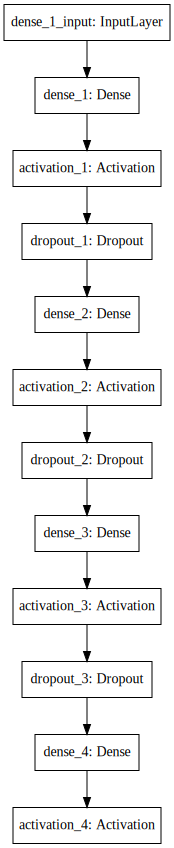

In [3]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [4]:
import json
from sklearn import preprocessing
from utils import preprocess_data, topKFrequentAnswer
data_question = json.load(open('Questions/OpenEnded_mscoco_train2014_questions.json'))
data_answer = json.load(open('Annotations/mscoco_train2014_annotations.json'))

data_qval = json.load(open('Questions/OpenEnded_mscoco_val2014_questions.json'))
data_aval = json.load(open('Annotations/mscoco_val2014_annotations.json'))

In [5]:
K_train_dict, K_val_dict, topKAnswers = topKFrequentAnswer(data_question, data_answer, data_qval, data_aval)

K_images_id, K_questions_id, K_questions, K_questions_len, K_answers = K_train_dict['images_id'], K_train_dict['questions_id'], K_train_dict['questions'], K_train_dict['questions_len'], K_train_dict['answers']
K_images_val_id, K_questions_val_id, K_questions_val, K_questions_val_len, K_answers_val = K_val_dict['images_id'], K_val_dict['questions_id'], K_val_dict['questions'], K_val_dict['questions_len'], K_val_dict['answers']

In [6]:
labelencoder = preprocessing.LabelEncoder()
labelencoder.fit(topKAnswers)

LabelEncoder()

## Evaluate the model

### Test on a single question

In [7]:
from features_processor import q_embedding
from utils import bow, bow_q123

In [8]:
data_test = json.load(open('Questions/OpenEnded_mscoco_test-dev2015_questions.json'))
img_test = json.load(open('COCO/annotations/image_info_test2014.json'))

In [9]:
def img_id_to_path(data_test, img_test):
    d = dict()
    imgtopath = dict()
    
    for img_info in img_test['images']:
        img_id = img_info['id']
        d[img_id] = img_info['file_name']
        
    for q in data_test['questions']:
        q_id = q['question_id']
        
        imgtopath[q_id] = d[q['image_id']]
        
    return imgtopath

In [10]:
qid_to_imgpath = img_id_to_path(data_test, img_test)

In [11]:
# create the bow of the top 1000 words in the questions
bow_q = bow(data_question, data_qval, K=1000)

# create the bow of the top 10-first word + top-10 second word + top-10 third word
bow_123 = bow_q123(data_question, data_qval, K=10)

### don't forget to load the weights

In [12]:
model.load_weights('weights/BOWQ_I/weights.12-2.82.hdf5')

#### load the embeddings for the test dataset + dict that maps image_id to index in matrix

In [13]:
import scipy.io

In [14]:
# load the embeddings for the test dataset into memory to speed the process
features_test = scipy.io.loadmat('preprocess_datas/VGG16_feats_test.mat')['features']

# Load dictionary that maps image_id to index in the matrix X of size (4096, nb_test_imgs)
img_id_to_idx = json.load(open('preprocess_datas/id_img_test_to_index.json'))

In [15]:
import matplotlib.pyplot as plt
import imageio
import numpy as np
%matplotlib inline

question:  How many pairs of scissors are there?
1 best top answer: 2 with probabiliy: 45.06
2 best top answer: 1 with probabiliy: 23.76
3 best top answer: 3 with probabiliy: 17.35
4 best top answer: 4 with probabiliy: 7.93
5 best top answer: 5 with probabiliy: 2.00


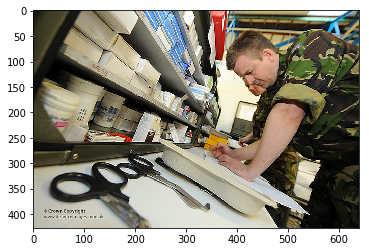

In [16]:
idx = 749 # idx of question

print("question: ", data_test['questions'][idx]['question'])

img_path = 'COCO/images_test/' + qid_to_imgpath[data_test['questions'][idx]['question_id']]
plt.imshow(imageio.imread(img_path))


q_feat = q_embedding(data_test['questions'][idx]['question'], bow_q, bow_123).reshape(1,-1)
idx_mat = img_id_to_idx["%s" % data_test['questions'][idx]['image_id']]
i_feat = features_test[:, idx_mat].reshape(1,-1)

feat = np.hstack((q_feat, i_feat))

final_proba = model.predict(feat)
top5_ans = np.argsort(final_proba)[0][::-1][:5]
for i, a in enumerate(top5_ans, 1):
    print("%d best top answer: %s with probabiliy: %.02f" % (i, labelencoder.inverse_transform(a), 100 * final_proba[0][a]))

### Test on our image and question

In [17]:
import models.vgg16 as my_model

How many sheep do you see?
2


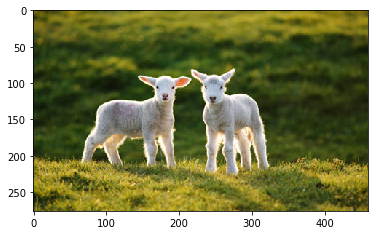

In [18]:
# question = 'What color is the bus?'
# img_path = 'our_images/bus.jpg'

question = 'How many sheep do you see?'
img_path = 'our_images/sheeps.jpg'

plt.imshow(imageio.imread(img_path))

q_feat = q_embedding(question, bow_q, bow_123).reshape(1,-1)
i_feat = my_model.extract_features(img_path, my_model.vgg16_model_extractfeatures)

feat = np.hstack((q_feat, i_feat))

y_pred = np.argmax(model.predict(feat))
print(question)
print(labelencoder.inverse_transform(y_pred))

## Compute the final accuracy of the model
We compute the final accuracy of the model using the formula:

$$\text{accuracy} = min(\frac{\text{# humans that provided that answer}}{3}, 1)$$

We do that on the validation set as we don't have access to the ground truth answers from the testing set and the website that provides the ground truth answers was updated with the ground truth answers of the 2017 dataset. As we are working on the 2015 version to be able to compare our results with the paper's results we are force to compute the accuracy on the validation set.

In [19]:
# load the embeddings for the test dataset into memory to speed the process
features = scipy.io.loadmat('preprocess_datas/VGG16_feats.mat')['features']

# Load dictionary that maps image_id to index in the matrix X of size (4096, nb_test_imgs)
img_id_to_idx = json.load(open('preprocess_datas/id_image_to_index.json'))

In [20]:
available_img_id = {v: 0 for v in K_questions_val_id}

In [21]:
# construct a list with the predicted answer from the model
pred_answers = []

i = 0

print(len(data_qval['questions']))

for ques in data_qval['questions']:
    if ques['question_id'] in available_img_id:

        q_feat = q_embedding(ques['question'], bow_q, bow_123).reshape(1,-1)
        idx_mat = img_id_to_idx["%s" % ques['image_id']]
        i_feat = features[:, idx_mat].reshape(1,-1)

        feat = np.hstack((q_feat, i_feat))
        
        pred = np.argmax(model.predict(feat))
        if i % 10000 == 0:
            print(i, end=' ', flush=True)
        pred_answers.append(labelencoder.inverse_transform(pred))
#         print(i+1, ques['question'])
#         print(labelencoder.inverse_transform(pred))
        i += 1

121512
0 10000 20000 30000 40000 50000 60000 70000 80000 90000 100000 

In [22]:
import csv
i = 0
true_multiple_answers = []

with open('preprocess_datas/multiple_answers.csv', 'r') as f:
    wr = csv.reader(f, quoting=csv.QUOTE_NONE)
    for row in wr:
        true_multiple_answers.append(row)

In [23]:
c = 0.0
cat_counter = {'yes/no': 0, 'other': 0, 'number': 0, 'all': 0}
cat = {'yes/no': 0, 'other': 0, 'number': 0, 'all': 0}


img_ptr = 0
q_ptr = 0

for obj in data_aval['annotations']:
    if (obj['image_id'] == K_images_val_id[img_ptr] and 
        obj['question_id'] == K_questions_val_id[q_ptr]):
        
        cat_counter[obj['answer_type']] += 1

        count = true_multiple_answers[img_ptr].count(pred_answers[img_ptr])
        if count > 2:
            cat[obj['answer_type']] += 1
            c += 1
        else:
            cat[obj['answer_type']] += float(count)/3
            c += float(count)/3
        
        img_ptr += 1
        q_ptr += 1

print('other accuracy on validation set: %.02f' % (100 * cat['other']/cat_counter['other']))
print('number accuracy on validation set: %.02f' % (100 * cat['number']/cat_counter['number']))
print('yes/no accuracy on validation set: %.02f' % (100 * cat['yes/no']/cat_counter['yes/no']))
print('final accuracy on validation set: %.02f' % (100 * c/len(data_aval['annotations'])))

other accuracy on validation set: 20.28
number accuracy on validation set: 36.57
yes/no accuracy on validation set: 72.01
final accuracy on validation set: 38.65
